In the context of **Auto-Encoders**, we want to compare between outputs at different layers using two kind of networks. Single Loss auto-encoder and multi-loss auto-encoder. And later on, we will try Multi-Weighted Loss auto-encoders.

## Import Relevant Packages

In [1]:
import torch
from torch import nn
from collections import OrderedDict
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torch_model_manager import TorchModelManager
import copy
import wandb

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.1) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
wandb.login(key = '50ec2df756bf2e8a273dc36f5a363b8e445c743f')
wandb.init(project="Image Clustering Based on Node-Edge Duality Message Passing Using Graph Attention Networks")

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/bimokhtari1/.netrc
wandb: Currently logged in as: b_mokhtari (billal-mokhtari). Use `wandb login --relogin` to force relogin


## I. Auto-Encoders with Default Loss Function

In [2]:
class Net(nn.Module):
    def __init__(self, input_dim, layers):
        super(Net, self).__init__()
        self.layers = self.create_layers(input_dim, layers)

    def create_layers(self, input_dim, layers):
        layer_list = []
        prev_dim = input_dim
        for idx, layer_dim in enumerate(layers):
            layer_list.append((f'fc{idx}', nn.Linear(prev_dim, layer_dim)))
            prev_dim = layer_dim

        return nn.Sequential(OrderedDict(layer_list))

    def forward(self, x):
        layers = []
        for layer in self.layers:
            x = layer(x)
            layers.append(x)
        return x, layers
        

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, layers=[64, 32, 16]):
        super(AutoEncoder, self).__init__()
        assert all(x>=y for x, y in zip(layers, layers[1:])), "Layers must be sorted in decreasing order"

        self.encoder = Net(input_dim, layers)

        self.decoder = Net(layers[-1], layers[-2::-1]+[input_dim])

    def forward(self, x):
        x, enc_layers = self.encoder(x)
        x, dec_layers = self.decoder(x)
        return x, enc_layers, dec_layers

In [4]:
x = torch.linspace(0, 5, 128)
vector = torch.exp(x)

layers_dim = [64, 32, 16, 8]
input_dim = 128
model = AutoEncoder(input_dim, layers_dim)

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.000001)

epochs = 1000000
for i in range(epochs):
    optimizer.zero_grad()
    output, enc_layers, dec_layers = model(vector)

    loss = criterion(output, vector)
    loss.backward()
    optimizer.step()
    print(f'----------------------- Epoch {i}/{epochs} -----------------------')
    print(f'Loss: {loss.item()}')
    for idx in range(len(layers_dim)-1):

        print(f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')
    if loss < 1:
        break



----------------------- Epoch 0/1000000 -----------------------
Loss: 2280.52685546875
Loss 64: 927.2067260742188
Loss 32: 381.7801818847656
Loss 16: 170.2649383544922
----------------------- Epoch 1/1000000 -----------------------
Loss: 2280.50146484375
Loss 64: 927.125732421875
Loss 32: 381.6708984375
Loss 16: 170.1327362060547
----------------------- Epoch 2/1000000 -----------------------
Loss: 2280.47607421875
Loss 64: 927.0451049804688
Loss 32: 381.56201171875
Loss 16: 170.0010528564453
----------------------- Epoch 3/1000000 -----------------------
Loss: 2280.450927734375
Loss 64: 926.964599609375
Loss 32: 381.4534606933594
Loss 16: 169.86990356445312
----------------------- Epoch 4/1000000 -----------------------
Loss: 2280.425537109375
Loss 64: 926.884521484375
Loss 32: 381.3452453613281
Loss 16: 169.7392578125
----------------------- Epoch 5/1000000 -----------------------
Loss: 2280.400390625
Loss 64: 926.8045654296875
Loss 32: 381.2373962402344
Loss 16: 169.60916137695312
-

In [5]:
def compare_input_output(input, output, title):
    # Create an array of indices
    indices = np.arange(len(output))

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(indices, input, label='Input')
    plt.plot(indices, output, label='Output')
    plt.xlabel('Index')
    plt.ylabel('Output')
    plt.title(title)
    plt.legend()
    plt.show()

### Compare the Output of the Final Layer

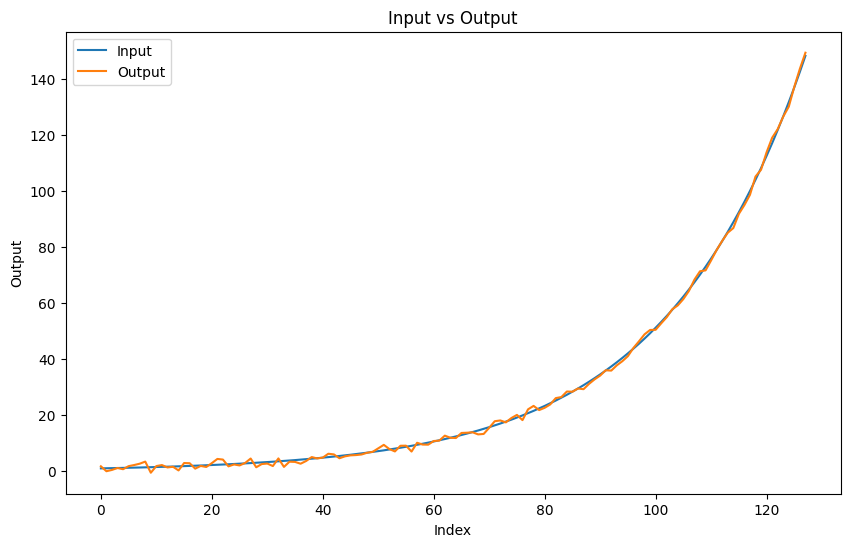

In [6]:
# compare_input_output(enc_layers[1].detach().numpy(), dec_layers[-3].detach().numpy())
compare_input_output(vector, model(vector)[0].detach(), title='Input vs Output')

### Compare the Outputs of Intermediate Layers

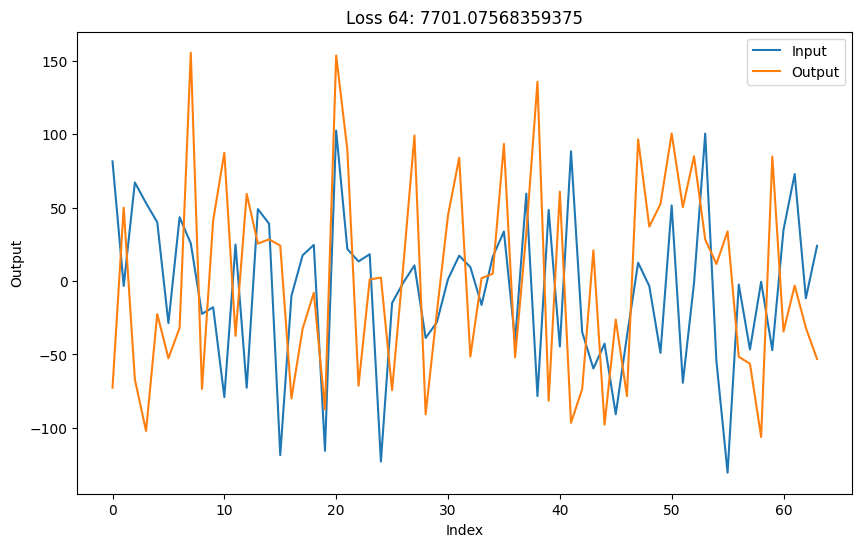

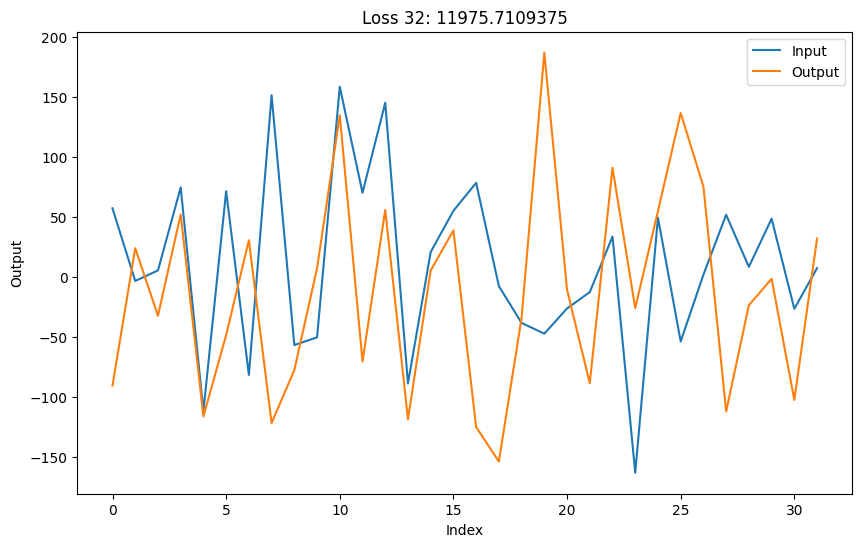

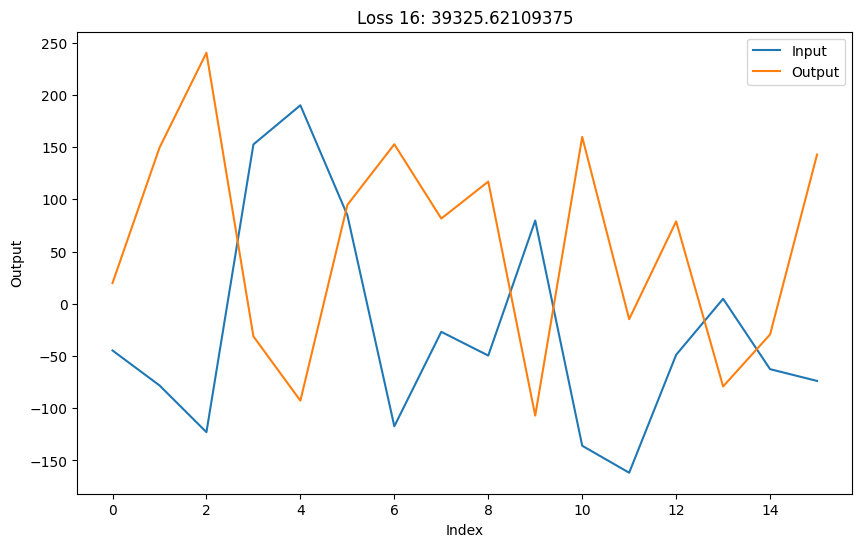

In [7]:
for idx in range(len(layers_dim)-1):
    compare_input_output(enc_layers[idx].detach().numpy(), dec_layers[-idx-2].detach().numpy(), title=f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')

## II. Auto-Encoders with Modified Loss Function

In [8]:
class AutoEncoderModified(nn.Module):
    def __init__(self, input_dim, layers=[64, 32, 16]):
        super(AutoEncoderModified, self).__init__()
        assert all(x>=y for x, y in zip(layers, layers[1:])), "Layers must be sorted in decreasing order"

        self.encoder = Net(input_dim, layers)
        self.decoder = Net(layers[-1], layers[-2::-1]+[input_dim])

    def forward(self, x):
        x, enc_layers = self.encoder(x)
        x, dec_layers = self.decoder(x)
        loss = criterion(x, vector)
        for idx in range(len(layers_dim)-1):
            loss += criterion(enc_layers[idx], dec_layers[-idx-2])
        
        return x, enc_layers, dec_layers, loss

In [9]:
aem = AutoEncoderModified(input_dim, layers_dim)
optimizer = torch.optim.Adam(aem.parameters(), lr=0.000001)
epochs = 100000000
for epoch in range(epochs):
    optimizer.zero_grad()
    output, enc_layers, dec_layers, loss = aem(vector)

    loss.backward()
    optimizer.step()

    print(f'----------------------- Epoch {epoch}/{epochs} -----------------------')
    print(f'Loss: {loss.item()}')

    if loss < 1:
        break



----------------------- Epoch 0/100000000 -----------------------
Loss: 3438.39794921875
----------------------- Epoch 1/100000000 -----------------------
Loss: 3438.0400390625
----------------------- Epoch 2/100000000 -----------------------
Loss: 3437.683349609375
----------------------- Epoch 3/100000000 -----------------------
Loss: 3437.326171875
----------------------- Epoch 4/100000000 -----------------------
Loss: 3436.96875
----------------------- Epoch 5/100000000 -----------------------
Loss: 3436.612060546875
----------------------- Epoch 6/100000000 -----------------------
Loss: 3436.255615234375
----------------------- Epoch 7/100000000 -----------------------
Loss: 3435.89892578125
----------------------- Epoch 8/100000000 -----------------------
Loss: 3435.54248046875
----------------------- Epoch 9/100000000 -----------------------
Loss: 3435.185791015625
----------------------- Epoch 10/100000000 -----------------------
Loss: 3434.82958984375
----------------------- E

----------------------- Epoch 41/100000000 -----------------------
Loss: 3423.8603515625
----------------------- Epoch 42/100000000 -----------------------
Loss: 3423.509033203125
----------------------- Epoch 43/100000000 -----------------------
Loss: 3423.158203125
----------------------- Epoch 44/100000000 -----------------------
Loss: 3422.807373046875
----------------------- Epoch 45/100000000 -----------------------
Loss: 3422.456787109375
----------------------- Epoch 46/100000000 -----------------------
Loss: 3422.106201171875
----------------------- Epoch 47/100000000 -----------------------
Loss: 3421.755859375
----------------------- Epoch 48/100000000 -----------------------
Loss: 3421.40576171875
----------------------- Epoch 49/100000000 -----------------------
Loss: 3421.055419921875
----------------------- Epoch 50/100000000 -----------------------
Loss: 3420.706298828125
----------------------- Epoch 51/100000000 -----------------------
Loss: 3420.356201171875
--------

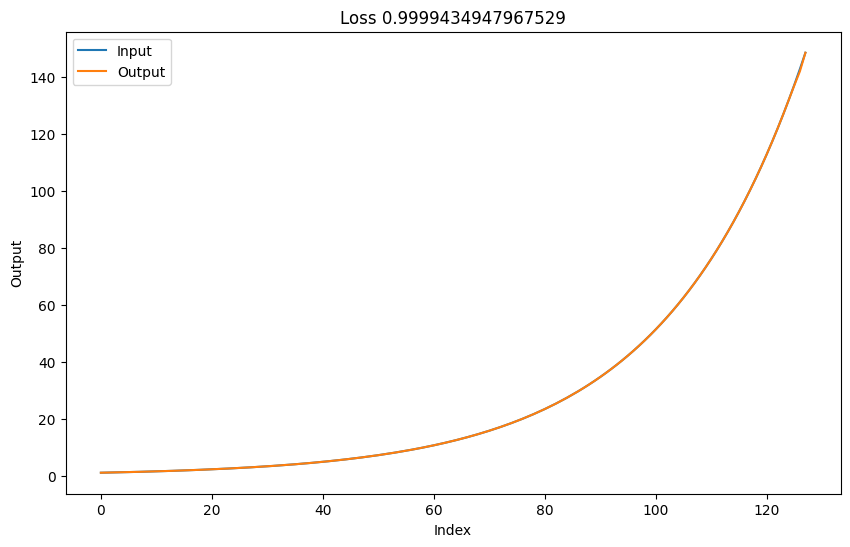

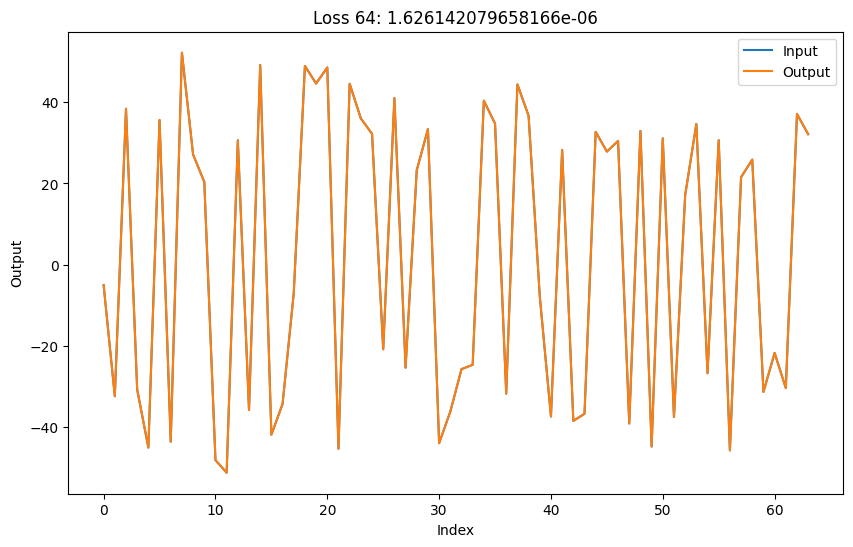

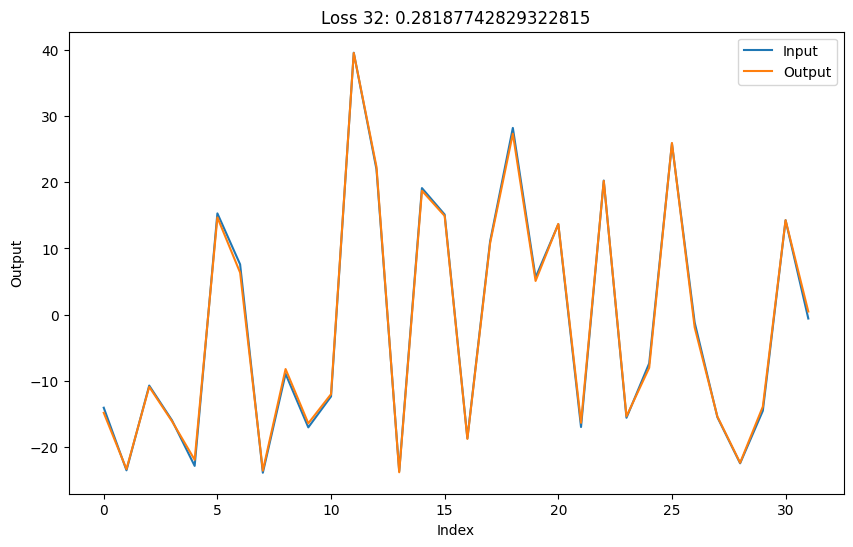

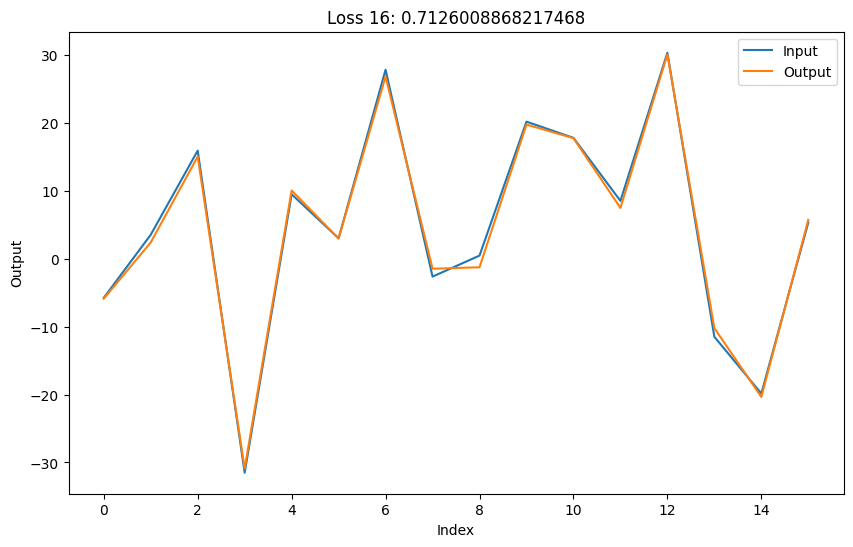

In [10]:
compare_input_output(vector, output.detach().numpy(), title=f'Loss {loss.item()}')
for idx in range(len(layers_dim)-1):
    compare_input_output(enc_layers[idx].detach().numpy(), dec_layers[-idx-2].detach().numpy(), title=f'Loss {layers_dim[idx]}: {criterion(enc_layers[idx], dec_layers[-idx-2])}')

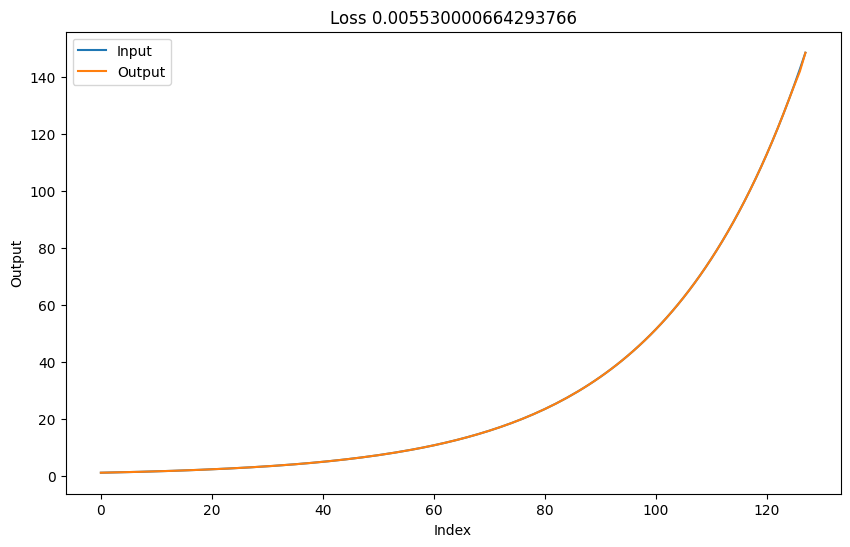

In [15]:
test = torch.linspace(0, 5, 128)
test = torch.exp(test)
compare_input_output(test, aem(test)[0].detach(), title=f"Loss {criterion(test, aem(test)[0].detach())}")

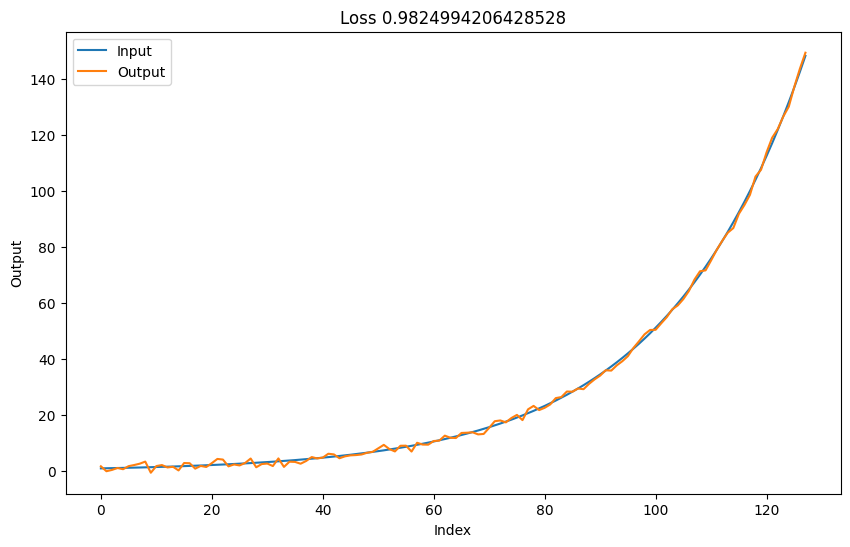

In [12]:
test = torch.linspace(0, 5, 128)
test = torch.exp(test)
compare_input_output(test, model(test)[0].detach(), title=f"Loss {criterion(test, model(test)[0].detach())}")